In [35]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import yfinance as yf
import matplotlib.pyplot as plt

# -----------------------------
# Data Download
# -----------------------------

stocks = ["AMAT", "NXPI"]
START = "2020-01-01"
rolling_window = 252
stock1, stock2 = stocks

data = yf.download(stocks, start=START)
df = data["Close"]


C:\Users\admin\AppData\Local\Temp\ipykernel_2596\2145960672.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stocks, start=START)
[*********************100%***********************]  2 of 2 completed


In [36]:
# -----------------------------
# Rolling Regression for Hedge Ratio
# -----------------------------

rolling_alpha = [np.nan] * rolling_window
rolling_beta = [np.nan] * rolling_window

for i in range(rolling_window, len(df)):
    past_data = df.iloc[i-rolling_window: i]
    X = past_data[stock1].values
    y = past_data[stock2].values

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    rolling_alpha.append(model.params[0])
    rolling_beta.append(model.params[1])

rolling_params = pd.DataFrame({"Alpha": rolling_alpha, "Beta": rolling_beta}, index=df.index)



<Axes: xlabel='Date'>

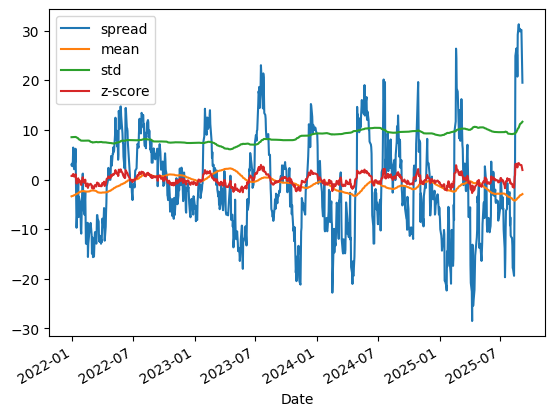

In [37]:
# -----------------------------
# Spread & Z-Score
# -----------------------------

spread = df[stock2] - (rolling_params["Alpha"] + rolling_params["Beta"] * df[stock1]) 
rolling_mean = spread.rolling(rolling_window).mean()
rolling_std = spread.rolling(rolling_window).std()
z_score = (spread - rolling_mean) / rolling_std
spread_data = pd.DataFrame({"spread": spread, 
                            "mean": rolling_mean,
                            "std": rolling_std,
                            "z-score": z_score},
                            index=df.index)


spread_data = pd.DataFrame({
    "spread": spread, 
    "mean": rolling_mean,
    "std": rolling_std,
    "z-score": z_score
}, index=df.index)


spread_data.dropna().plot()

In [41]:
# -----------------------------
# Trading Signals
# -----------------------------
entry_threshold = 1.5
exit_threshold = 0.5

signals = pd.Series(0, index=z_score.index)

signals[z_score > entry_threshold] = -1   # Short spread
signals[z_score < -entry_threshold] = 1   # Long spread
signals[(z_score < exit_threshold) & (z_score > -exit_threshold)] = 0  # Exit

positions = signals.replace(to_replace=0, method="ffill").fillna(0)

daily_returns = df.pct_change()
spread_returns = daily_returns[stock2] - rolling_params["Beta"] * daily_returns[stock1]
print(spread_returns.tail())

Date
2025-08-29    0.005297
2025-09-02    0.007172
2025-09-03   -0.012285
2025-09-04   -0.022655
2025-09-05   -0.016856
dtype: float64


In [42]:
# -----------------------------
# Trailing Stop (30-day volatility)
# -----------------------------
stop_mult = 2
vol_30d = spread.rolling(30).std()

strategy_returns = []
position_history = []
position = 0
cum_pnl = 1
peak_pnl = 1

for i in range(len(spread_returns)):
    if np.isnan(spread_returns.iloc[i]) or np.isnan(vol_30d.iloc[i]):
        strategy_returns.append(0)
        position_history.append(0)
        continue
    
    intended_pos = positions.iloc[i-1] if i > 0 else 0
    threshold = stop_mult * vol_30d.iloc[i]
    dd = (cum_pnl - peak_pnl) / peak_pnl  
    
    if dd < -threshold:
        position = 0
    else:
        position = intended_pos
    
    ret = position * spread_returns.iloc[i]
    cum_pnl *= (1 + ret)
    peak_pnl = max(peak_pnl, cum_pnl)
    
    strategy_returns.append(ret)
    position_history.append(position)

strategy_returns = pd.Series(strategy_returns, index=spread_returns.index)
cum_returns = (1 + strategy_returns).cumprod()
position_history = pd.Series(position_history, index=spread_returns.index)

print(position_history)

Date
2020-01-02    0
2020-01-03    0
2020-01-06    0
2020-01-07    0
2020-01-08    0
             ..
2025-08-29   -1
2025-09-02   -1
2025-09-03   -1
2025-09-04   -1
2025-09-05   -1
Length: 1427, dtype: int64


In [43]:
# -----------------------------
# Performance Metrics
# -----------------------------
def performance_metrics(returns, cum_returns, freq=252, rf=0.0):
    cumulative_return = cum_returns.iloc[-1] - 1
    cagr = (cum_returns.iloc[-1])**(freq/len(returns)) - 1
    volatility = returns.std() * np.sqrt(freq)
    sharpe = (returns.mean() * freq - rf) / volatility if volatility != 0 else np.nan
    downside = returns[returns < 0].std() * np.sqrt(freq)
    sortino = (returns.mean() * freq - rf) / downside if downside != 0 else np.nan
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_dd = drawdown.min()
    
    return {
        "Total Return": f"{cumulative_return:.2%}",
        "CAGR": f"{cagr:.2%}",
        "Volatility": f"{volatility:.2%}",
        "Sharpe Ratio": round(sharpe, 2),
        "Sortino Ratio": round(sortino, 2),
        "Max Drawdown": f"{max_dd:.2%}"
    }

metrics = performance_metrics(strategy_returns.dropna(), cum_returns)

print("Performance Metrics with Trailing Stop:")
for k, v in metrics.items():
    print(f"{k}: {v}")



Performance Metrics with Trailing Stop:
Total Return: 325.78%
CAGR: 29.15%
Volatility: 22.28%
Sharpe Ratio: 1.26
Sortino Ratio: 1.55
Max Drawdown: -17.42%


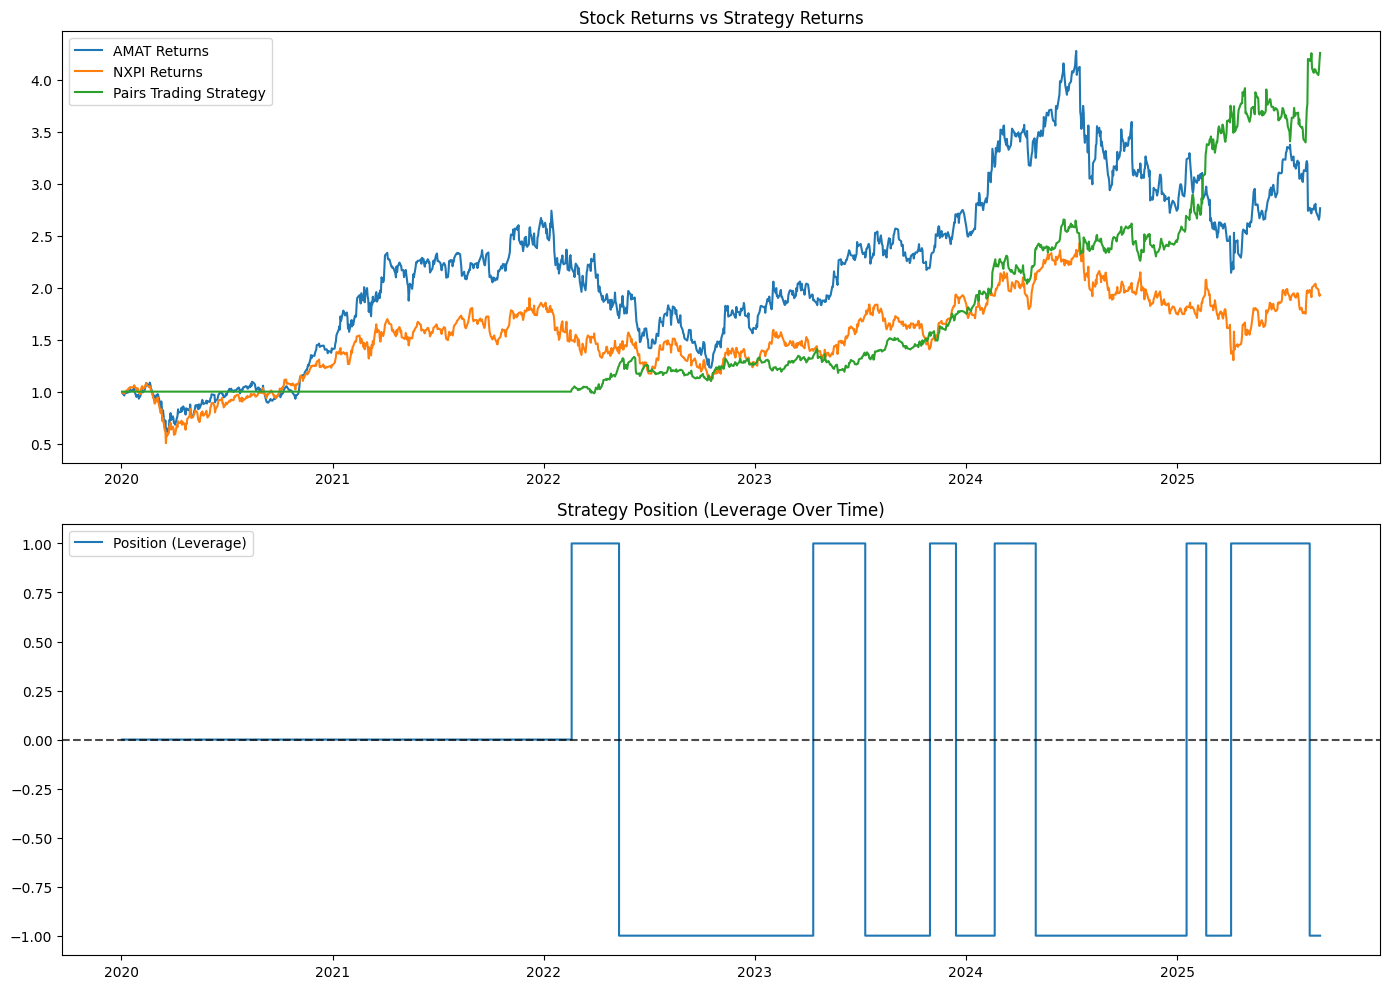

In [45]:
# -----------------------------
# Plotting
# -----------------------------
plt.figure(figsize=(14,10))

plt.subplot(2,1,1)
plt.plot((1+daily_returns[stock1]).cumprod(), label=f"{stock1} Returns")
plt.plot((1+daily_returns[stock2]).cumprod(), label=f"{stock2} Returns")
plt.plot(cum_returns, label="Pairs Trading Strategy")
plt.title("Stock Returns vs Strategy Returns")
plt.legend()

plt.subplot(2,1,2)
plt.plot(position_history, drawstyle="steps-post", label="Position (Leverage)")
plt.title("Strategy Position (Leverage Over Time)")
plt.axhline(0, color="black", linestyle="--", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()